<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/modelo_monod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Análisis de estabilidad del modelo del bioreactor continuo para determinar el efecto del parámetro $D$ sobre la productividad de biomasa y etanol en el estado estacionario

Autor: Juan Manuel Gutiérrez García

Fecha: Enero 2021

In [1]:
 # instalar librerías
install.packages("deSolve")
install.packages("xlsx")
install.packages("GA")
install.packages("rootSolve")
install.packages("FME")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rJava’, ‘xlsxjars’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘minpack.lm’, ‘minqa’




In [18]:
# cargar librerias
library(deSolve)
library(ggplot2)
library(xlsx)
library(GA)

In [3]:
# establecer modelo de Monod
model <- function(times, state, parms) {
  with(as.list(c(state, parms)), {

    # velocidad de crecimiento (Monod)
    rx = mu_max*s/(ks + s)*x

    # velocidad de consumo de sustrato
    rs = (1/Yxs)*rx

    # balance de materia para el sustrato
    dsdt = D*(sf - s) - rs

    # balance de materia para la biomasa
    dxdt = rx - D*x

    return(list(c(dsdt,dxdt))) 
  })
}

In [4]:
# establecer parámetros 
p <- c(mu_max = 1.453, ks = 284.399, Yxs = 0.109, D =  0.01, sf = 20)

In [5]:
# condiciones iniciales
s <- c(s = 10, x = 2)

In [6]:
# función para calcular los puntos de equilibrio
steady_state <- function(p) {
  with(as.list(p), {

    # primer punto de equilibrio
    s = sf
    x = 0
    ss1 = c(s = s, x = x)

    # segundo punto de equilibrio
    s = D*ks/(mu_max - D)
    x = Yxs*(sf-s)
    ss2 = c(s = s, x = x)

  return(list(ss1 = round(ss1, 3),ss2 = round(ss2, 3)))
  })
}

In [7]:
ss <- steady_state(p)
ss

$ss1
 s  x 
20  0 

$ss2
    s     x 
1.971 1.965

In [8]:
# ds/dt = 0 nullcline
null_cline <- function(p,s) {
    with(as.list(p),{
        x = Yxs*D*(sf - s)*(ks + s)/(mu_max*s)
        return(x)
    })
}

In [22]:
plot_null_cline <- function(p,s_ss){
    ss <- steady_state(p)
    x_ss <- null_cline(p,s_ss)
    par(mar = c(5,7,4,2) + 0.1)
    # ds/dt = 0 nullcline
    plot(s_ss, x_ss, col = "red", cex.lab = 1.6, cex.axis = 1.5, lwd = 3, type = "l",
    ylim = c(0,3), ylab = "Concentración de biomasa (g/L)",
    xlab = "Concentración de sustrato  (g/L)")
    # dx/dt = 0 nulcline
    abline(h = 0, col = "blue", lwd = 3, lty = 2)
    abline(v = ss$ss2[1], col = "blue", lwd = 3, lty = 2)
    points(ss$ss1[1],ss$ss1[2], col = "deepskyblue1", cex = 4, pch = 20) # 
    points(ss$ss2[1],ss$ss2[2], col = "firebrick", cex = 3, pch = 17)
    points(s[1],s[2], cex = 2, pch = 20)
    run(traject = T, times = seq(0,1000,0.1), lwd = 4)
    legend("topright", legend = c("ds/dt = 0", "dx/dt = 0"), lty = 1:2, lwd = 3,
     col = c("red","blue"), cex = 1.5, bty = "n")

}

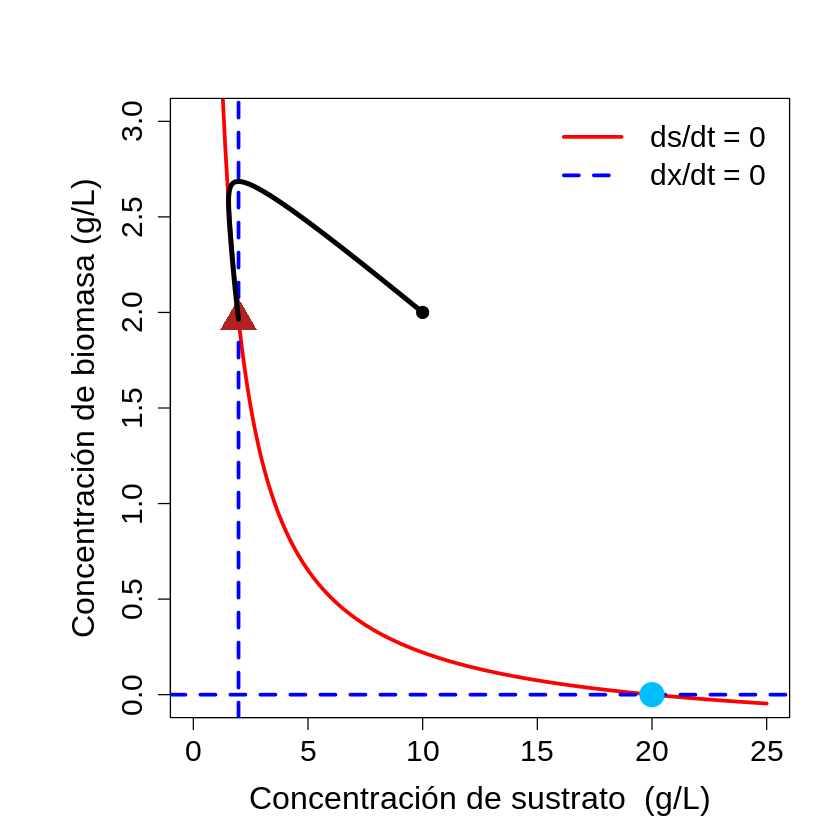

In [23]:
s_ss <- seq(0,25,0.1)
plot_null_cline(p,s_ss)

## Efecto del parámetro D sobre el punto de equilibrio

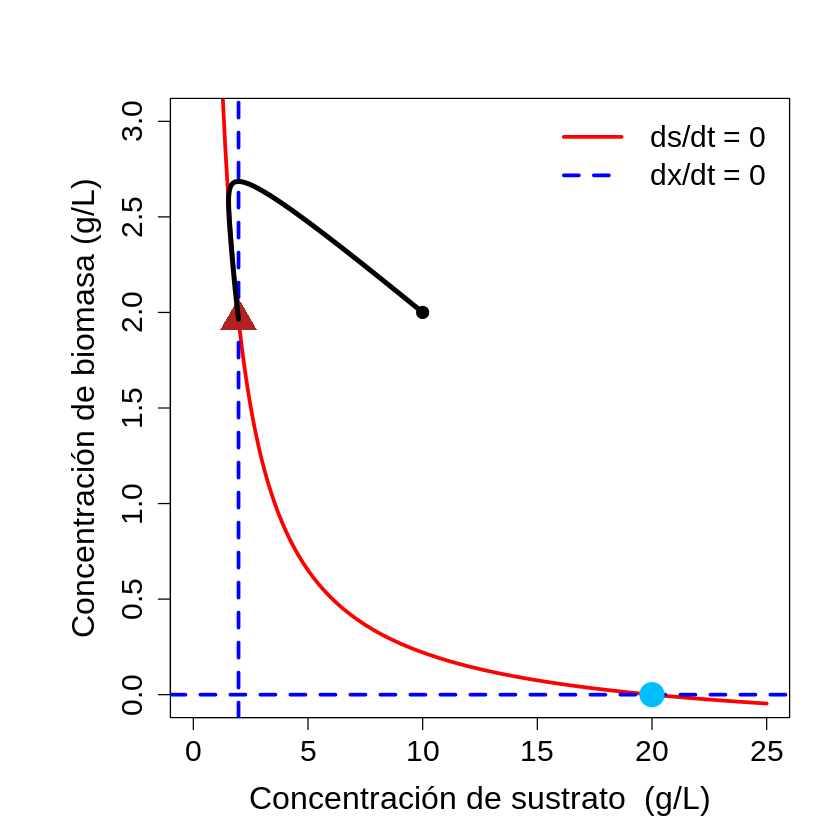

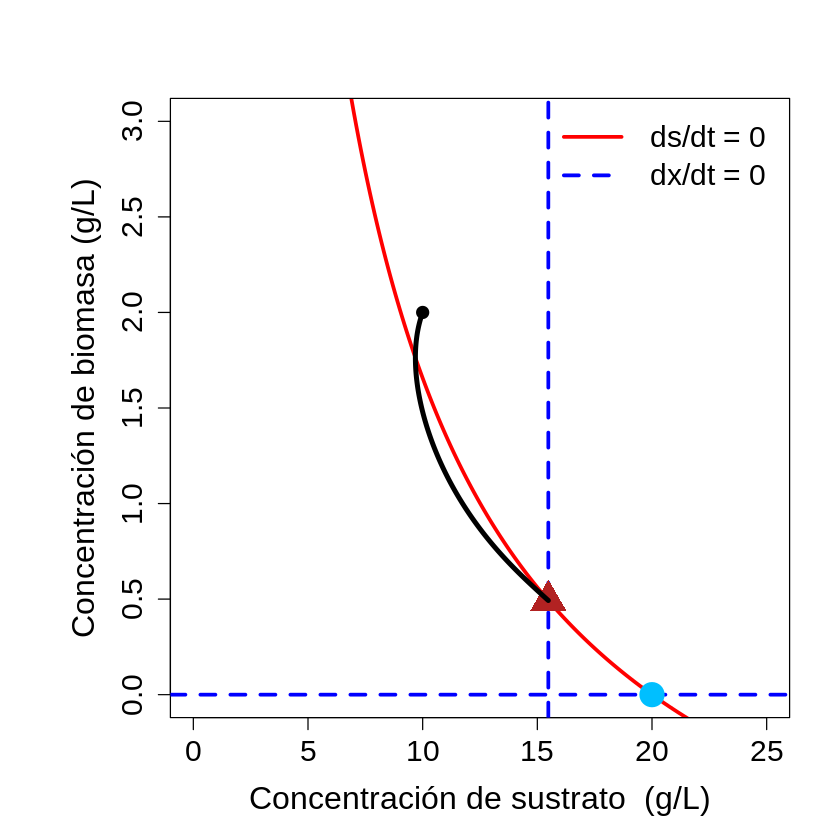

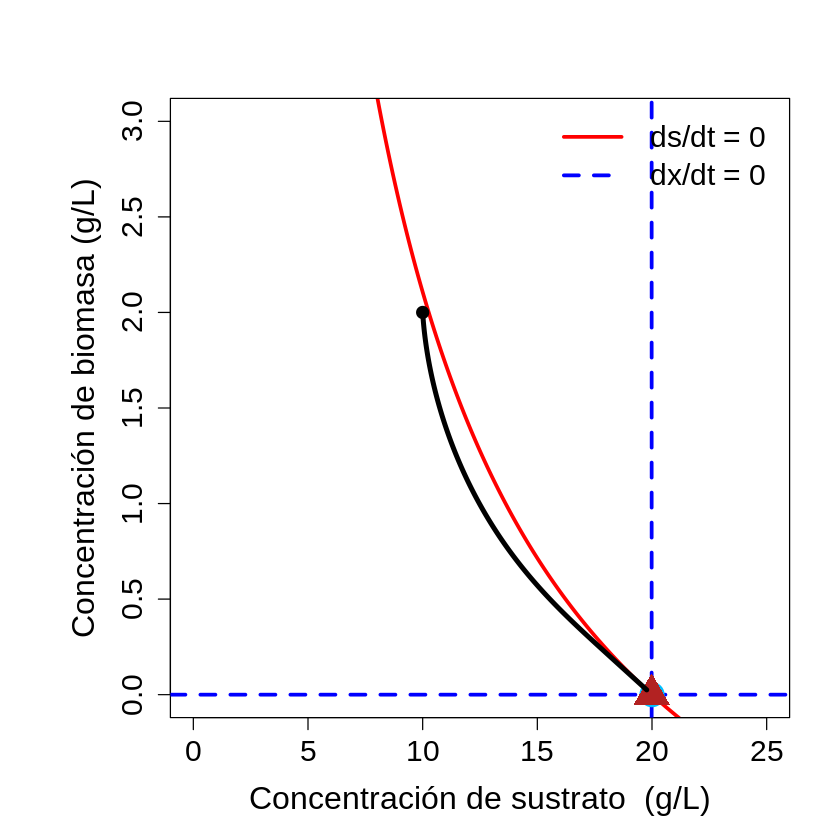

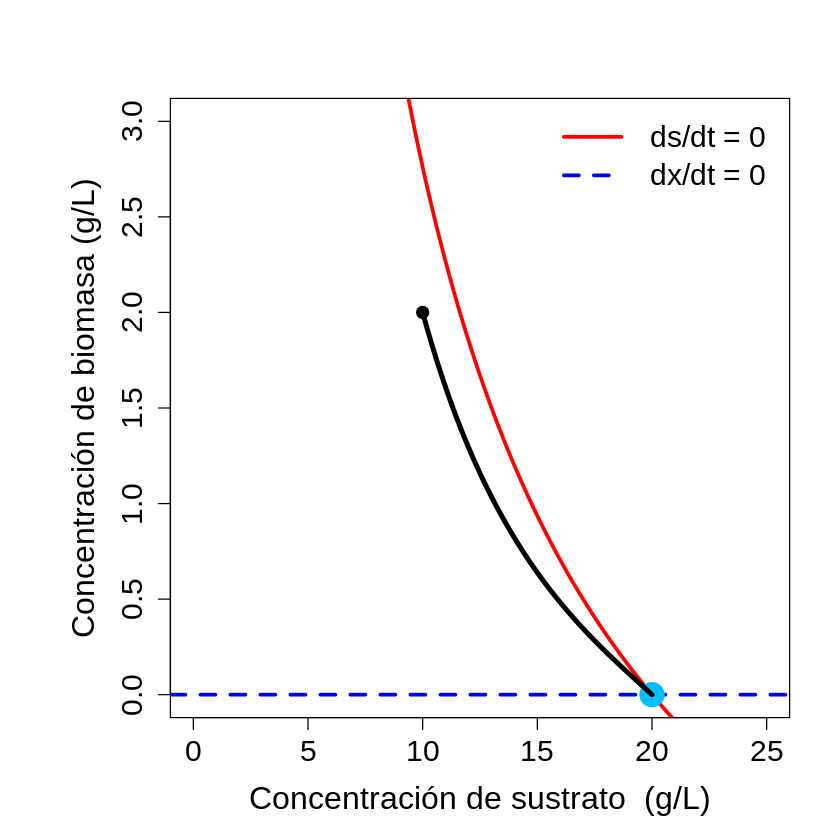

In [24]:
for (D in c(0.01,0.075,0.0954,0.125)) {
    p["D"] <- D
    plot_null_cline(p,s_ss)
}
p["D"] <- 0.01

In [25]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {
    D = mu_max*sf/(ks + sf)
    return(D)
  })
}

In [26]:
# calcular Dbif
cat("Dbif: ", D_bif(p), "(1/h)")

Dbif:  0.09546681 (1/h)

## Diagrama de bifurcación 

In [27]:
# bifurcation diagram 
bifurcation_s <- function(x) {
        with(as.list(p),{
                # segundo punto de equilibrio
                s = x*ks/(mu_max - x)
                x = Yxs*(sf-s)
                ss2 = list(s = s, x = x)
                return(ss2)
        })  
}

In [28]:
# valores de D a evualuar
D_p <- seq(0,D_bif(p),0.001)

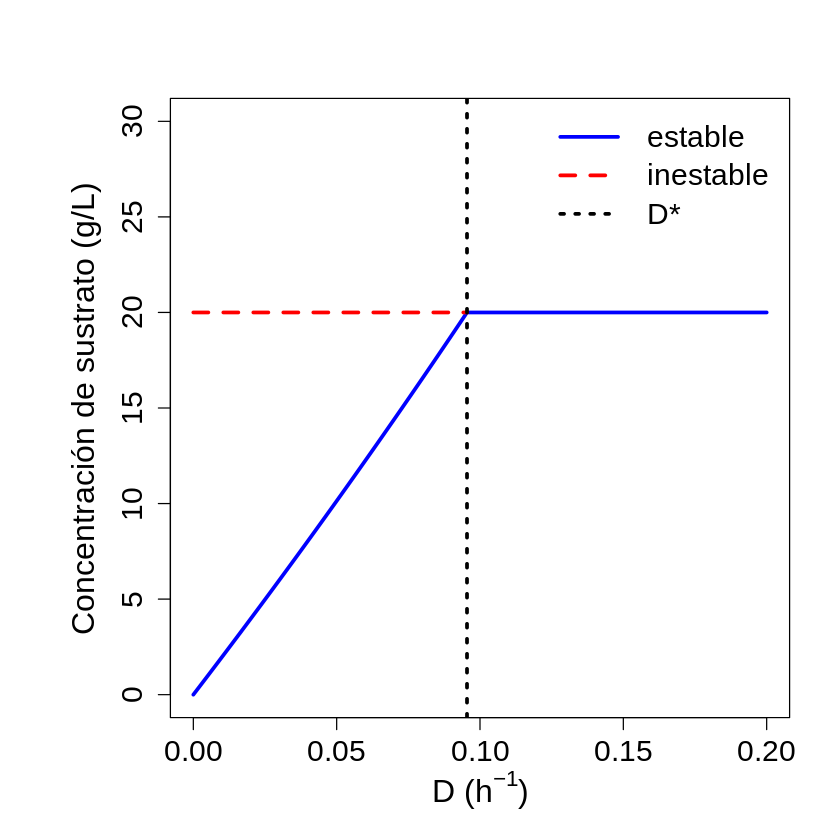

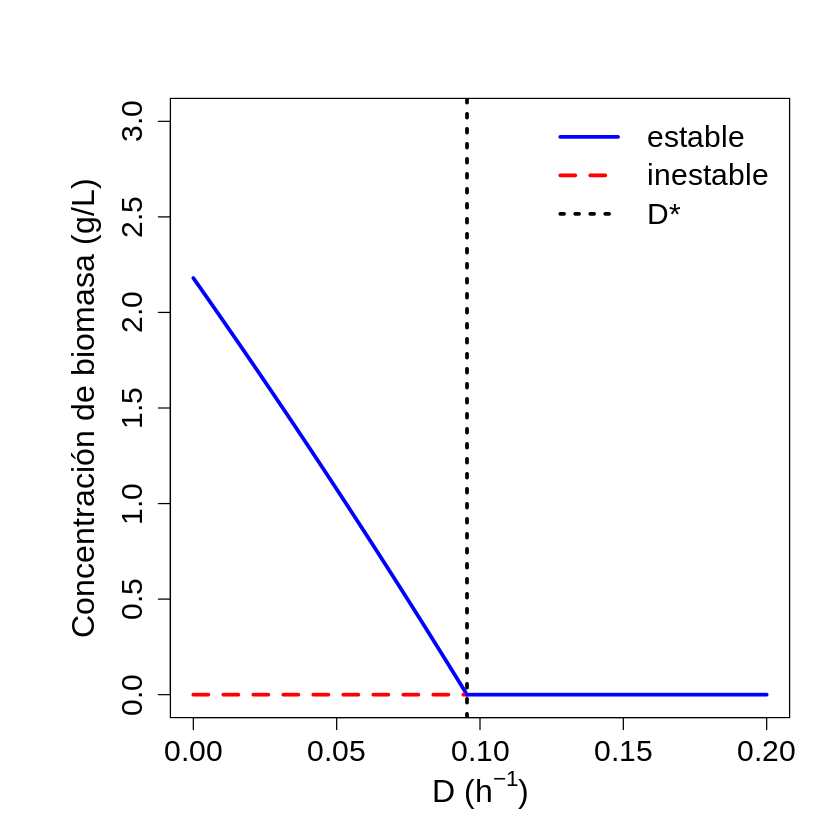

In [29]:
ss <- bifurcation_s(D_p)
par(mar = c(5,7,4,2) + 0.1)
plot(c(0,0.2), c(0,30), xlab = expression("D ("*h^-1*")"), ylab = "Concentración de sustrato (g/L)",
    type = "n", cex.lab = 1.6, cex.axis = 1.5)
lines(D_p, ss$s, col = "blue", lwd = 3)
lines(c(D_bif(p), 0.2), rep(p["sf"],2), col = "blue", lwd = 3)
lines(c(0, D_bif(p)), rep(p["sf"],2), col = "red", lwd = 3, lty = 2)
abline(v = D_bif(p), lwd = 3, lty = 3)
legend("topright", legend = c("estable", "inestable", "D*"), lty = c(1,2,3), lwd = 3,
     col = c("blue","red","black"), cex = 1.5, bty = "n")
par(mar = c(5,7,4,2) + 0.1)
plot(c(0,0.2), c(0,3), xlab = expression("D ("*h^-1*")"), ylab = "Concentración de biomasa (g/L)",
    type = "n", cex.lab = 1.6, cex.axis = 1.5)
lines(D_p, ss$x, col = "blue", lwd = 3)
lines(c(0, D_bif(p)), rep(0,2), col = "red", lwd = 3, lty = 2)
lines(c(D_bif(p), 0.2), rep(0,2), col = "blue", lwd = 3)
abline(v = D_bif(p), lwd = 3, lty = 3)
legend("topright", legend = c("estable", "inestable", "D*"), lty = c(1,2,3), lwd = 3,
     col = c("blue","red","black"), cex = 1.5, bty = "n")

## Linealización

Las derivadas parciales en la matriz Jacobiana se pueden obtener mediante la librería `sympy` de Python

https://github.com/JuanM-GG/modelos-tesis/blob/main/linealizacion_monod.ipynb

In [34]:
# función que calcula la matriz Jacobiana en el punto de equilibrio 
my_jacobi <- function(ss,p) {
  with(as.list(c(ss,p)), {

    dfdx = mu_max*s/(ks + s) - D
    dfds = mu_max*ks*x/(ks + s)**2
    dgdx = -(1/Yxs)*mu_max*s/(ks + s)
    dgds = -D - (1/Yxs)*mu_max*ks*x/(ks + s)**2

    J = matrix(c(dfdx,dfds,dgdx,dgds), nrow = 2, byrow = T)

    trace = dfdx + dgds

    det = dfdx*dgds - dgdx*dfds

    lamda1 = (trace - (trace**2 - 4*det)^{1/2})/2
    lamda2 = (trace + (trace**2 - 4*det)^{1/2})/2

    out = list(J = J, eigenvals = c(lamda1 = round(lamda1, 3), lamda2 = round(lamda2, 3)))

    return(out)

  })
}

In [35]:
print(p)

 mu_max      ks     Yxs       D      sf 
  1.453 284.399   0.109   0.010  20.000 


In [36]:
# obtener puntos de equilibrio 
ss1 <- steady_state(p)$ss1
ss2 <- steady_state(p)$ss2

cat("ss1: \n")
cat("s = ",ss1[1],"x = ",ss1[2],"\n")
cat("ss2: \n")
cat("s = ",ss2[1],"x = ",ss2[2],"\n")

ss1: 
s =  20 x =  0 
ss2: 
s =  1.971 x =  1.965 


In [37]:
# evaluar matriz Jacobiana en punto de equilibrio ss1 (s = sf, x = 0)
J1 <- my_jacobi(ss1, p)
print(J1)

$J
            [,1]  [,2]
[1,]  0.08546681  0.00
[2,] -0.87584225 -0.01

$eigenvals
lamda1 lamda2 
-0.010  0.085 



Dado que el signo de los eigenvalores es opuesto, el punto de equilibrio $ss_1$  es inestable, en particular, es un punto silla

In [38]:
# evaluar matriz Jacobiana en punto de equilibrio (s = k*D/(mu-D), x = y*(sf-s*))
J2 <- my_jacobi(ss2, p)
print(J2)

$J
              [,1]         [,2]
[1,]  5.691937e-07  0.009901505
[2,] -9.174834e-02 -0.100839492

$eigenvals
lamda1 lamda2 
-0.091 -0.010 



Dado que ambos eigenvalores tienen signo negativo, el punto de equilibrio $ss_2$ es estable. En este caso, porque los eigenvalores son números reales, sabemos que el ´punto de equilibrio es un nodo estable.

#	Análisis dinámico (integración numérica)

A continuación realizamos la integración numérica para evaluar el comportamiento dinámico del modelo

Aquí es importante recordad el valor de los parámetros que hemos establecido 

In [39]:
print(p)

 mu_max      ks     Yxs       D      sf 
  1.453 284.399   0.109   0.010  20.000 


In [40]:
# tiempo de simulación 
times <- seq(0,500,len=1000)

In [41]:
# resolver EDOs
out <- ode(func = model, y = s, times = times, parms = p, method = "rk4")

In [43]:
# guardar resultados
out <- as.data.frame(out)

# añadir condiciones de estado estacionario
out$s_ss <- rep(ss2[1], length(times))
out$x_ss <- rep(ss2[2], length(times))

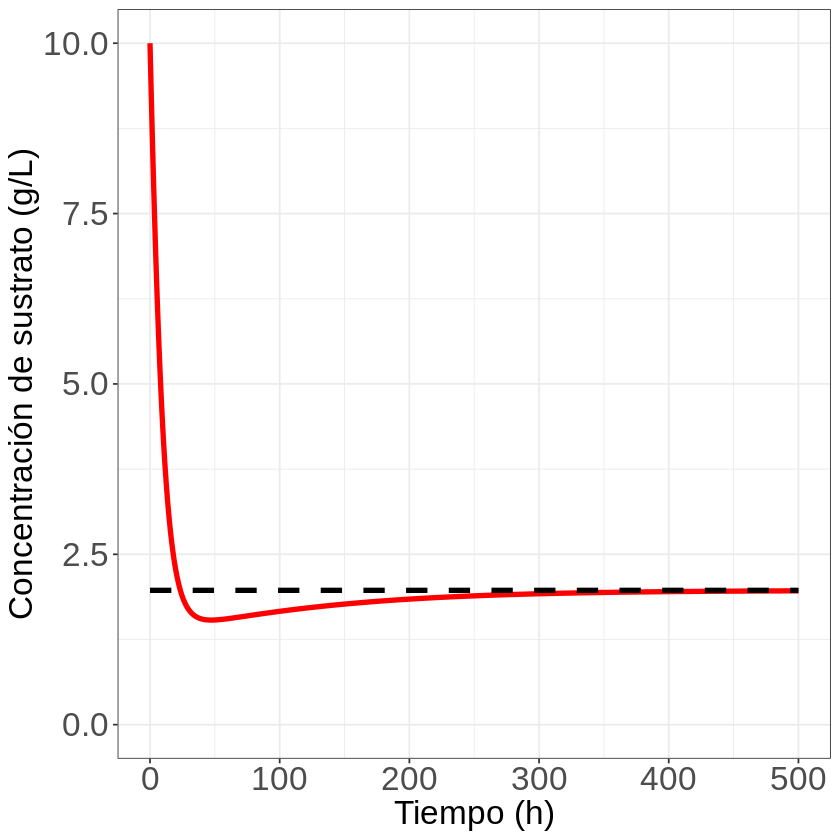

In [44]:
# mostrar resultados de sustrato
ggplot(out, aes(time)) +
  geom_line(aes(y = s, color = "Sustrato"), lwd = 1.5) +
  geom_line(aes(y = s_ss, color = "Estado estable"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concentración de sustrato (g/L)") + 
  ylim(c(0,10)) +
  scale_color_manual("", breaks = c("Sustrato","Estado estable"), values = c("red", "black")) +
  theme_bw() +
  theme(legend.position = "none",
        axis.text=element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20)) 

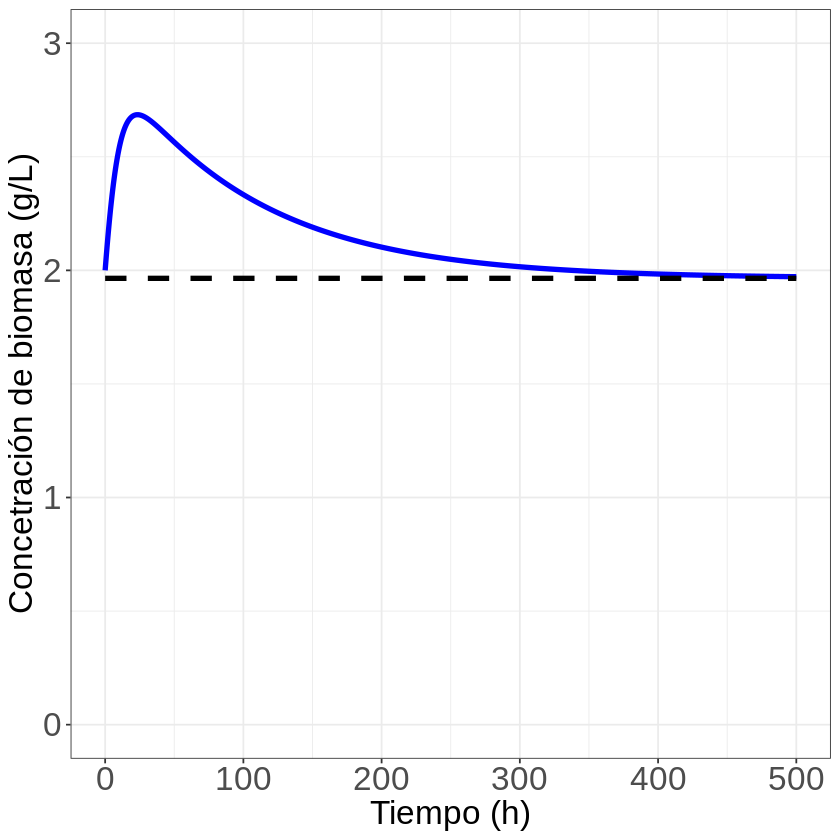

In [45]:
# mostrar resultados de biomasa 
ggplot(out, aes(time)) +
  geom_line(aes(y=x, color = "Biomasa"), lwd = 1.5, lty = 1) +
  geom_line(aes(y=x_ss, color = "Estado estable"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concetración de biomasa (g/L)") + 
  ylim(c(0,3))+
  scale_color_manual("", breaks = c("Biomasa","Estado estable"), values = c("blue", "black")) +
  theme_bw() +
  theme(legend.position = "none",
        axis.text=element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20)) 

Vemos que el sistema tiende al estado estacionario  $ss_2$, lo cual concuerda con el análisis de estabilidad que hemos realizado. 

In [46]:
p["D"] <- 0.125
# resolver EDOs
out <- ode(func = model, y = s, times = times, parms = p, method = "rk4")

In [47]:
s_ss <- steady_state(p)
p["D"] <- 0.01

In [48]:
# guardar resultados
out <- as.data.frame(out)
# añadir puntos de equilibrio 
out$s_ss <- rep(ss1[1], length(times))
out$x_ss <- rep(ss1[2], length(times))

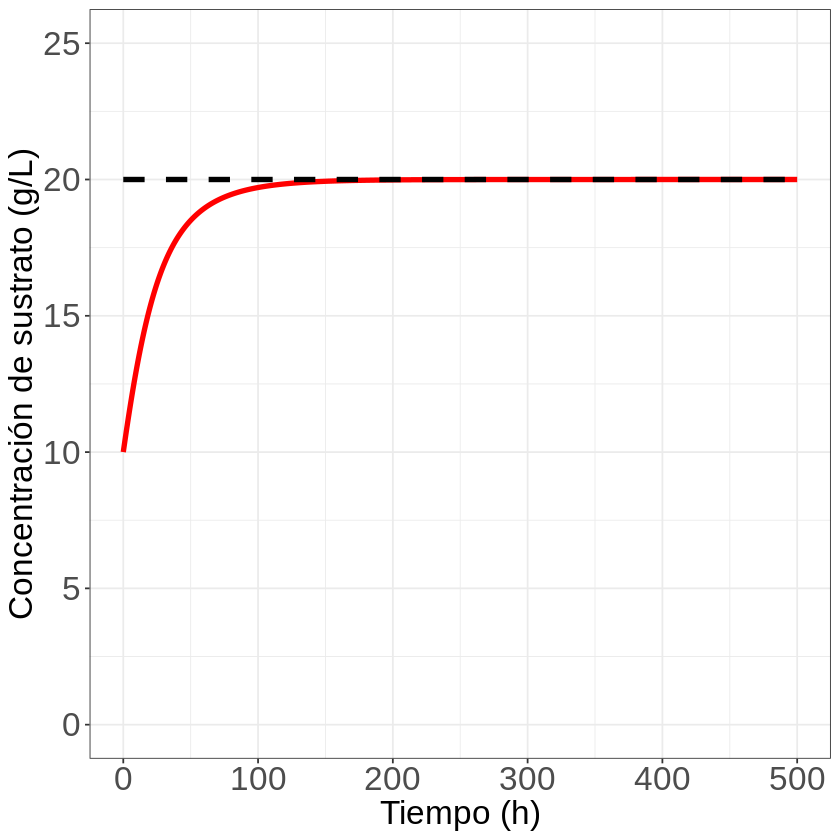

In [49]:
# mostrar resultados de sustrato
ggplot(out, aes(time)) +
  geom_line(aes(y = s, color = "Sustrato"), lwd = 1.5) +
  geom_line(aes(y = s_ss, color = "Estado estable"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concentración de sustrato (g/L)") + 
  ylim(c(0,25)) +
  scale_color_manual("", breaks = c("Sustrato","Estado estable"), values = c("red", "black")) +
  theme_bw() +
  theme(legend.position = "none",
        axis.text=element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20)) 

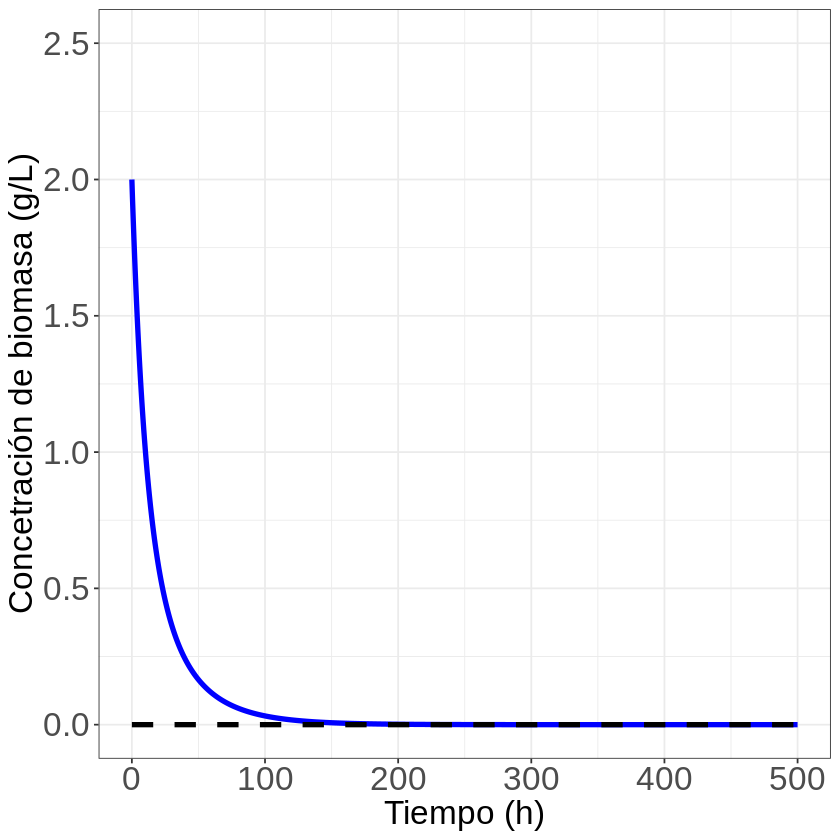

In [50]:
# mostrar resultados de biomasa 
ggplot(out, aes(time)) +
  geom_line(aes(y=x, color = "Biomasa"), lwd = 1.5, lty = 1) +
  geom_line(aes(y=x_ss, color = "Estado estable"), lwd = 1.5, lty = 2) +
  xlab("Tiempo (h)") +
  ylab("Concetración de biomasa (g/L)") + 
  ylim(c(0,2.5))+
  scale_color_manual("", breaks = c("Biomasa","Estado estable"), values = c("blue", "black")) +
  theme_bw() +
  theme(legend.position = "none",
        axis.text=element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20)) 

Vemos que para todas las condiciones iniciales que se evaluaron, el sistema siempre tiene al punto de equilibrio $ss_2$